In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast/uncertainty


In [2]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, BatchNormalization, Lambda, 
                                     concatenate, Embedding, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import BatchCreator, Logger
from model_builder import get_pinball_losses, get_simple_dist_model, get_simple_dense_model
from flow import model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model
from preprocess import preprocess, get_features, pandas_cat_data


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Optimise MLP - level 10 - entity embedding
See:  
Cheng Guo and Felix Berkhahn, "Entity Embeddings of Categorical Variables", April 25, 2016, https://arxiv.org/pdf/1604.06737.pdf.

In [4]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [5]:
level = 10

model_dir = 'models/uncertainty/hyper_opt/level_{}/'.format(level)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## Read data

In [6]:
if level <= 9:
    fn = data_dir + 'prep/level_{}_simple_fe_2011_01_29_2016_04_24_normalised_demand.pickle'.format(level)
else:
    fn = data_dir + 'prep/level_{}_simple_fe_2014_04_26_2016_04_24_normalised_demand.pickle'.format(level)

# check if already preprocessed
if os.path.exists(fn):
    data = pd.read_pickle(fn)
else:
    # choose number of years to include
    if level <= 9:
        n_years = 6  # all
    else:
        n_years = 2
    
    # preform preprocessing
    data = preprocess(level=level, n_years=n_years, save_prepared_dataset=True, data_dir=data_dir)
    
# set categorical features
data, available_cat_features = pandas_cat_data(data)

# select features
sell_price_features = ('sell_price' in data.columns)
features = get_features(level=level, sell_price_features=sell_price_features)
print(features)

['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'shift_t28', 'shift_t29', 'shift_t30', 'rolling_std_t7', 'rolling_std_t30', 'rolling_std_t60', 'rolling_std_t90', 'rolling_std_t180', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 'rolling_mean_t90', 'rolling_mean_t180', 'rolling_skew_t30', 'rolling_kurt_t30', 'year', 'month', 'week', 'day', 'dayofweek', 'is_year_end', 'is_year_start', 'is_quarter_end', 'is_quarter_start', 'is_month_end', 'is_month_start', 'is_weekend', 'cat_id', 'dept_id', 'item_id']


In [7]:
# Replace the NaN in these categories with as a new category
for col in ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']:
    data[col] = data[col].cat.add_categories(-1).fillna(-1)

In [8]:
from sklearn.preprocessing import LabelEncoder

for col in available_cat_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

## Setup training

In [9]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [10]:
def get_generators(batch_size=1024):
    labels = ['demand']
    train_batch_creator = BatchCreator(x_train, features, labels, categorical_features=available_cat_features,
                                      batch_size=batch_size)
    val_batch_creator = BatchCreator(x_val, features, labels, shuffle=False, ensure_all_samples=True,
                                     categorical_features=available_cat_features, batch_size=batch_size)
    
    return train_batch_creator, val_batch_creator

# setup for training
train_batch_creator, val_batch_creator = get_generators()

# determine model input shape
x, y = next(train_batch_creator.flow())
INP_SHAPE = x[0].shape

# make losses
losses = get_pinball_losses()

# lazy evaluation of model
def lazy_evaluate_model(model):
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    return metrics, df

## Reference: train Dist(256) model

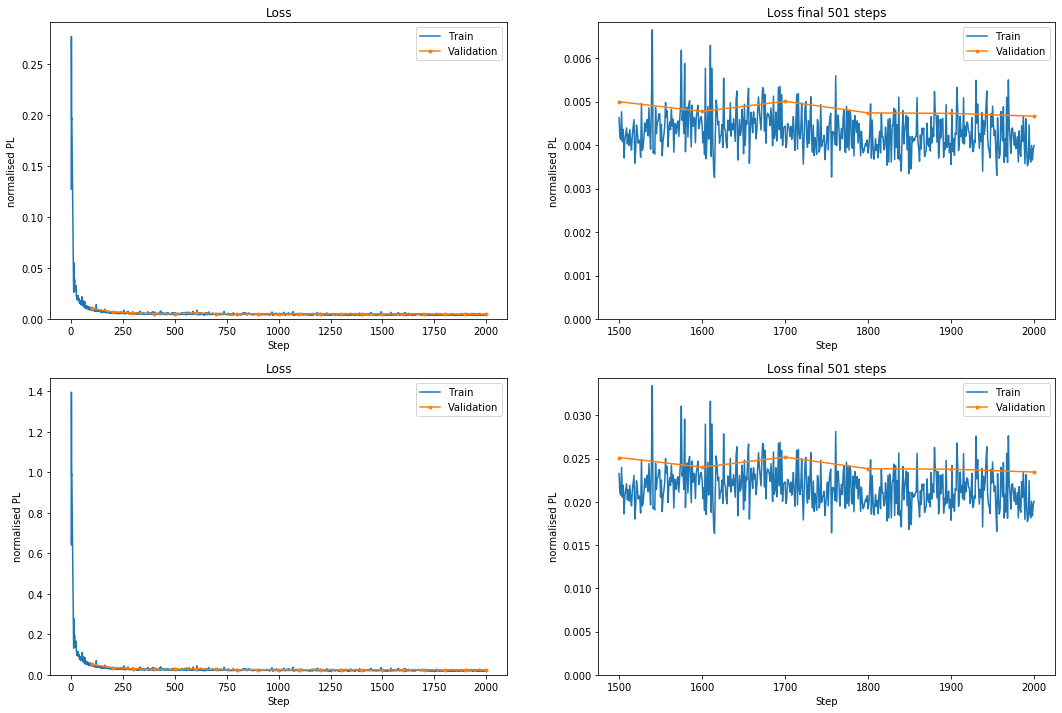

100/100 [==============================] - 48s 480ms/step - loss: 0.0042 - q0_loss: 3.5475e-05 - q1_loss: 1.3807e-04 - q2_loss: 5.7032e-04 - q3_loss: 7.3816e-04 - q4_loss: 9.7323e-04 - q5_loss: 8.2674e-04 - q6_loss: 6.7189e-04 - q7_loss: 1.9851e-04 - q8_loss: 7.1653e-05 - val_loss: 0.0047 - val_q0_loss: 5.2760e-05 - val_q1_loss: 1.7442e-04 - val_q2_loss: 6.6086e-04 - val_q3_loss: 8.3678e-04 - val_q4_loss: 0.0011 - val_q5_loss: 8.8280e-04 - val_q6_loss: 7.1506e-04 - val_q7_loss: 2.0949e-04 - val_q8_loss: 7.3921e-05


In [41]:
# setup
model = get_simple_dist_model(inp_shape=INP_SHAPE, num_nodes=256)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses)
logger = Logger(val_batch_creator)

# train
history = model.fit(train_batch_creator.flow(), epochs=20, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.22279384762407228, 'WSPL': 0.22279384762407228}


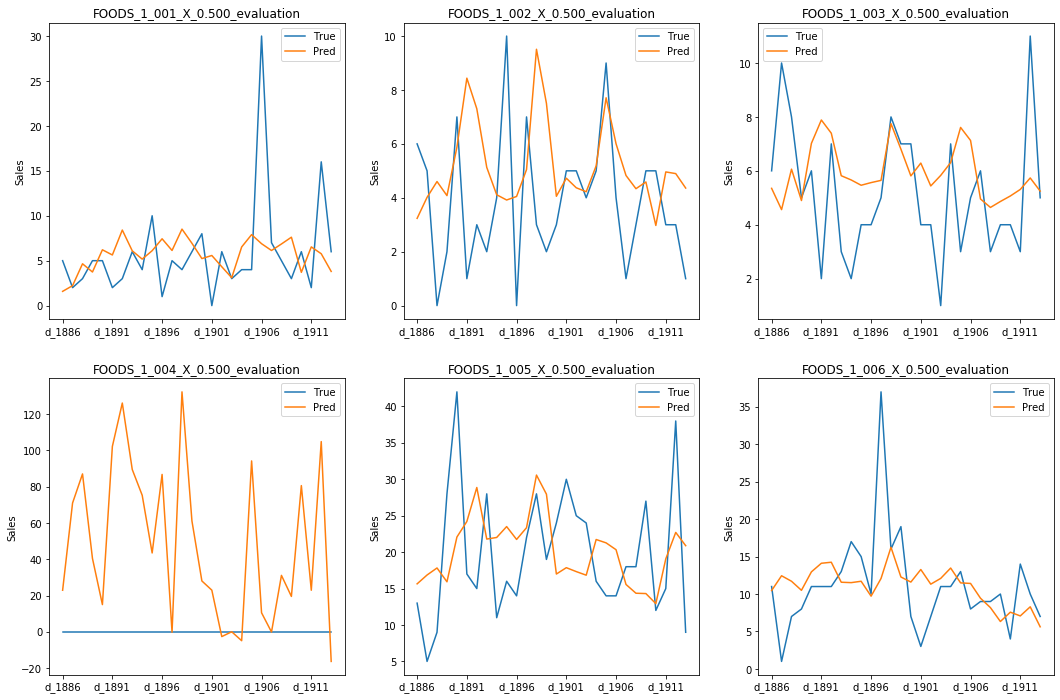

In [42]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

## Implement Embedding layer

### Step 1: Obtain multi-input for categorical features

In [17]:
features

['event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'shift_t28',
 'shift_t29',
 'shift_t30',
 'rolling_std_t7',
 'rolling_std_t30',
 'rolling_std_t60',
 'rolling_std_t90',
 'rolling_std_t180',
 'rolling_mean_t7',
 'rolling_mean_t30',
 'rolling_mean_t60',
 'rolling_mean_t90',
 'rolling_mean_t180',
 'rolling_skew_t30',
 'rolling_kurt_t30',
 'year',
 'month',
 'week',
 'day',
 'dayofweek',
 'is_year_end',
 'is_year_start',
 'is_quarter_end',
 'is_quarter_start',
 'is_month_end',
 'is_month_start',
 'is_weekend',
 'cat_id',
 'dept_id',
 'item_id']

In [18]:
available_cat_features

['item_id',
 'dept_id',
 'cat_id',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'year',
 'month',
 'week',
 'day',
 'dayofweek']

In [19]:
plain_features = [f for f in features if f not in available_cat_features]
plain_features

['snap_CA',
 'snap_TX',
 'snap_WI',
 'shift_t28',
 'shift_t29',
 'shift_t30',
 'rolling_std_t7',
 'rolling_std_t30',
 'rolling_std_t60',
 'rolling_std_t90',
 'rolling_std_t180',
 'rolling_mean_t7',
 'rolling_mean_t30',
 'rolling_mean_t60',
 'rolling_mean_t90',
 'rolling_mean_t180',
 'rolling_skew_t30',
 'rolling_kurt_t30',
 'is_year_end',
 'is_year_start',
 'is_quarter_end',
 'is_quarter_start',
 'is_month_end',
 'is_month_start',
 'is_weekend']

In [80]:
class BatchCreator(Sequence):
    """Batch creator for M5 Uncertainty challenge.
    - batch_size: number of samples per batch. Note: if ensure_all_samples is True,
                  the final batch size may be smaller.
    - shuffle: whether to shuffle the samples.
    - ensure_all_samples: whether to ensure all samples are yielded. If False (default),
                          the batch size is always constant.
    - inp_shape: input shape of how a single sample enters the neural network. This is without the batch size.
    - categorical_features: which columns to convert to one-hot encoding
    """

    def __init__(self, df, features, labels, batch_size=128, shuffle=True, ensure_all_samples=False,
                 inp_shape=(3244,), out_shape=(9,), categorical_features=None, multi_input_categorical=False):
        """Initialization"""
        # Save settings
        self.df = df
        self.list_IDs = self.df.index
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.ensure_all_samples = ensure_all_samples
        self.inp_shape = inp_shape
        self.out_shape = out_shape
        self.categorical_features = categorical_features
        self.multi_input_categorical = multi_input_categorical

        # initialize indices
        self.indexes = None
        self.on_epoch_end()

        # calculate properties
        self.n = self.df.index.size

    def __len__(self):
        """Denotes the number of batches per epoch"""
        if self.ensure_all_samples:
            return int(np.ceil(self.n / self.batch_size))
        return self.n // self.batch_size

    def __getitem__(self, index):
        """Generate one batch of data"""

        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = self.list_IDs[indexes]

        # Generate data
        x_batch, y_batch = self.__data_generation(list_IDs_temp)

        return x_batch, y_batch

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""

        # fill labels
        demand = self.df.loc[list_IDs_temp, 'demand'].values.astype(np.float32)
        y_batch = {'q%d' % d: demand for d in range(9)}

        # fill features
        if not self.multi_input_categorical:
            x_batch = self.df.loc[list_IDs_temp, self.features]
            x_batch = pd.get_dummies(x_batch, columns=self.categorical_features)
            
            # convert nan to zero
            x_batch = x_batch.astype(np.float32)
            mask = x_batch.isna()
            x_batch[mask] = 0
            
            # convert to numpy
            x_batch = x_batch.values
        else:
            x_batch = {}
            x_batch['input_plain'] = self.df.loc[list_IDs_temp, self.features]
            x_batch['input_plain'] = x_batch['input_plain'].astype(np.float32)
            mask = x_batch['input_plain'].isna()
            x_batch['input_plain'][mask] = 0
            x_batch['input_plain'] = x_batch['input_plain'].values
            
            for col in self.categorical_features:
                x_batch['input_'+col] = self.df.loc[list_IDs_temp, col].values.astype(int)[:, np.newaxis]
            
            
        return x_batch, y_batch

    def flow(self, epochs=None):
        """returns a generator that will yield batches infinitely"""
        epochs_done = 0
        while True:
            for index in range(self.__len__()):
                batch_x, batch_y = self.__getitem__(index)
                yield batch_x, batch_y

            # track nr. of epochs
            epochs_done += 1
            if epochs is not None and epochs_done == epochs:
                break  # stop yielding new elements

            # do on epoch end
            self.on_epoch_end()

In [81]:
embed_shapes_inp = {col: x_train[col].nunique() for col in available_cat_features}
embed_shapes_inp

{'item_id': 3049,
 'dept_id': 7,
 'cat_id': 3,
 'event_name_1': 31,
 'event_type_1': 5,
 'event_name_2': 2,
 'event_type_2': 2,
 'year': 3,
 'month': 12,
 'week': 53,
 'day': 31,
 'dayofweek': 7}

In [82]:
embed_shapes_out = {
    'item_id': 10,
    'dept_id': 2,
    'cat_id': 2,
    'event_name_1': 10,
    'event_type_1': 2,
    'event_name_2': 2,
    'event_type_2': 2,
    'year': 1,
    'month': 2,
    'week': 2,
    'day': 2,
    'dayofweek': 2
}

### Intermezzo: train with plain features

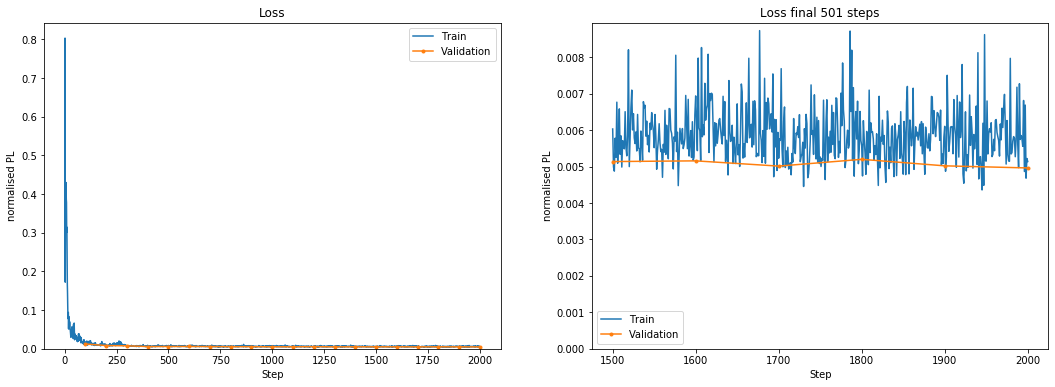

100/100 [==============================] - 9s 89ms/step - loss: 0.0058 - q0_loss: 4.7141e-05 - q1_loss: 1.8402e-04 - q2_loss: 7.0416e-04 - q3_loss: 8.8598e-04 - q4_loss: 0.0012 - q5_loss: 0.0011 - q6_loss: 9.6972e-04 - q7_loss: 4.4077e-04 - q8_loss: 2.8041e-04 - val_loss: 0.0050 - val_q0_loss: 5.0249e-05 - val_q1_loss: 1.9324e-04 - val_q2_loss: 7.2347e-04 - val_q3_loss: 8.8315e-04 - val_q4_loss: 0.0011 - val_q5_loss: 9.3097e-04 - val_q6_loss: 7.7523e-04 - val_q7_loss: 2.4307e-04 - val_q8_loss: 9.2239e-05


In [23]:
labels, batch_size = ['demand'], 1024

train_batch_creator = BatchCreator(x_train, plain_features, labels, categorical_features=[],
                                  batch_size=batch_size)
val_batch_creator = BatchCreator(x_val, plain_features, labels, shuffle=False, ensure_all_samples=True,
                                 categorical_features=[], batch_size=batch_size)

# determine model input shape
x, y = next(train_batch_creator.flow())
INP_SHAPE = x[0].shape

# make losses
losses = get_pinball_losses()

# setup
model = get_simple_dist_model(inp_shape=INP_SHAPE, num_nodes=256)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses)
logger = Logger(val_batch_creator)

# train
history = model.fit(train_batch_creator.flow(), epochs=20, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.23479962678927405, 'WSPL': 0.23479962678927405}


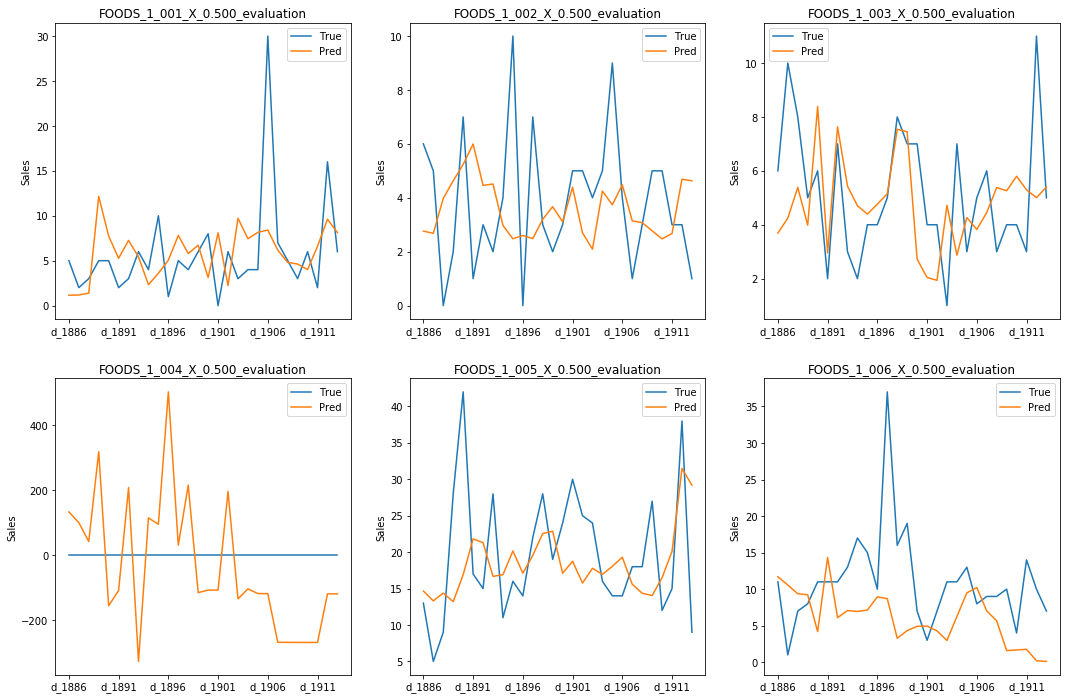

In [24]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

### Step 2: construct model

In [128]:
# Lambda layer: https://blog.paperspace.com/working-with-the-lambda-layer-in-keras/
def get_custom_layer(sigma_coef):
    def custom_layer(tensor):
        tensor1 = tensor[0]
        tensor2 = tensor[1]
        return tensor1 + sigma_coef * tensor2

    return custom_layer

def get_embed_dist_model(inp_shape, embed_shapes_inp, embed_shapes_out, num_nodes=64, sigma_coefs=None):
    if sigma_coefs is None:
        sigma_coefs = [-2.57583, -1.95996, -0.974114, -0.674, 0, 0.674, 0.9741114, 1.95996, 2.57583]

    # clear previous sessions
    K.clear_session()
    
    # setup regular input
    model_inputs = []
    inp = Input(inp_shape, name="input_plain")
    model_inputs.append(inp)
    
    # setup embeddings
    embedding_outputs = []
    for col in embed_shapes_inp.keys():
        # col is 'item_id', etc.
        embed_inp = Input(shape=(1,), name='input_'+col) # categorical enters as '7', or '102', etc.
        model_inputs.append(embed_inp)
        
        # embed
        n_possible_values = embed_shapes_inp[col]
        n_output_dim = embed_shapes_out[col]
        embed_out = Embedding(n_possible_values, n_output_dim, name='embedding_'+col)(embed_inp)
        embed_out = Reshape(target_shape=(n_output_dim,))(embed_out)
        
        # save list of embed outputs
        embedding_outputs.append(embed_out)
    
    # concatenate inputs
    x = concatenate([inp, *embedding_outputs])
    x = Dense(num_nodes, activation="relu")(x)
    x = Dense(num_nodes, activation="relu")(x)
    x = Dense(num_nodes, activation="relu")(x)

    mu = Dense(1)(x)  # represents mu
    sigma = Dense(1, activation="relu")(x)  # represents sigma
    
    outs = []

    for i, sigma_coef in enumerate(sigma_coefs):
        custom_layer = get_custom_layer(sigma_coef=sigma_coef)
        out_q = Lambda(custom_layer, name="q{}".format(i))([mu, sigma])
        outs.append(out_q)

    model = Model(inputs=model_inputs, outputs=outs)

    return model

### Test with plain and dept_id features

In [129]:
batch_size, labels = 1024, ['demand']
train_batch_creator = BatchCreator(x_train, features=plain_features, labels=labels, 
                                   categorical_features=['dept_id'],
                                   batch_size=batch_size, multi_input_categorical=True)
val_batch_creator = BatchCreator(x_val, features=plain_features, labels=labels, 
                                 categorical_features=['dept_id'],
                                 batch_size=batch_size, multi_input_categorical=True,
                                 ensure_all_samples=True, shuffle=False)

In [130]:
# model setup
INP_SHAPE = len(plain_features)
model = get_embed_dist_model(INP_SHAPE, {'dept_id': embed_shapes_inp['dept_id']}, 
                             {'dept_id': embed_shapes_out['dept_id']}, num_nodes=256)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

logger = Logger(val_batch_creator)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_dept_id (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_dept_id (Embedding)   (None, 1, 2)         14          input_dept_id[0][0]              
__________________________________________________________________________________________________
input_plain (InputLayer)        [(None, 25)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 2)            0           embedding_dept_id[0][0]          
______________________________________________________________________________________________

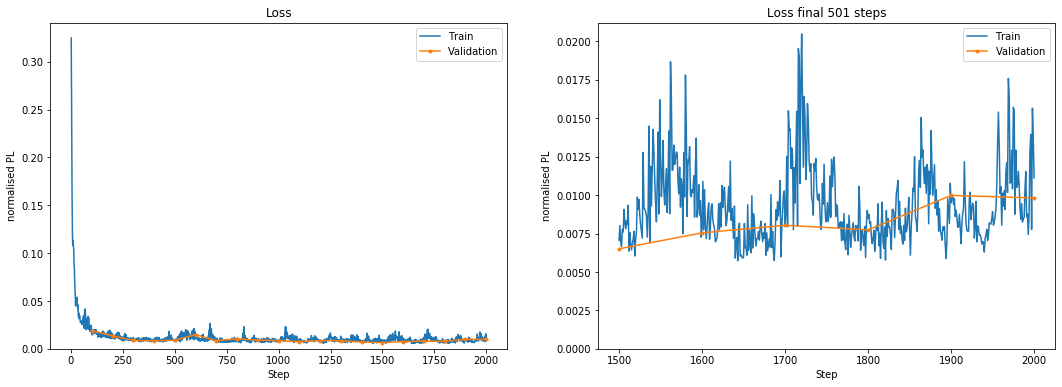

100/100 [==============================] - 9s 91ms/step - loss: 0.0096 - q0_loss: 2.9626e-04 - q1_loss: 5.1930e-04 - q2_loss: 0.0013 - q3_loss: 0.0015 - q4_loss: 0.0017 - q5_loss: 0.0017 - q6_loss: 0.0015 - q7_loss: 7.3253e-04 - q8_loss: 4.9343e-04 - val_loss: 0.0098 - val_q0_loss: 9.4254e-05 - val_q1_loss: 3.6954e-04 - val_q2_loss: 0.0015 - val_q3_loss: 0.0018 - val_q4_loss: 0.0020 - val_q5_loss: 0.0015 - val_q6_loss: 0.0013 - val_q7_loss: 7.6040e-04 - val_q8_loss: 5.6336e-04


In [131]:
# train
history = model.fit(train_batch_creator.flow(), epochs=20, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

### Full model

In [143]:
batch_size, labels = 1024, ['demand']
train_batch_creator = BatchCreator(x_train, features=plain_features, labels=labels, 
                                   categorical_features=available_cat_features,
                                   batch_size=batch_size, multi_input_categorical=True)
val_batch_creator = BatchCreator(x_val, features=plain_features, labels=labels, 
                                 categorical_features=available_cat_features,
                                 batch_size=batch_size, multi_input_categorical=True,
                                 ensure_all_samples=True, shuffle=False)

In [125]:
# model setup
INP_SHAPE = len(plain_features)
model = get_embed_dist_model(INP_SHAPE, embed_shapes_inp, embed_shapes_out, num_nodes=256)
model.compile(optimizer=Adam(learning_rate=1e-5), loss=losses)
model.summary()

logger = Logger(val_batch_creator)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_item_id (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_dept_id (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_cat_id (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_event_name_1 (InputLayer) [(None, 1)]          0                                            
______________________________________________________________________________________________

In [134]:
from tensorflow.keras.callbacks import LearningRateScheduler

def get_pyramid_lr(lr_start=0.01, lr_max=0.5, n_epoch=100, n_epochs_end=10):
    """LR pyramidal scheduler function. Ramps up linearly from lr_start to lr_max,
    then back to lr_start and finished with an additional slope to 1/10th of lr_start.
    To be combined with tf.keras.callbacks.LearningRateScheduler"""
    def lr_pyramid_scheduler(epoch, lr):
        n_epoch_half_pyramid = int(np.ceil(n_epoch/2 - n_epochs_end/2))
        lr_range = np.concatenate((
            np.linspace(lr_start, lr_max, num=n_epoch_half_pyramid),
            np.linspace(lr_max, lr_start, num=n_epoch_half_pyramid),
            np.linspace(lr_start, lr_start/10, num=n_epochs_end)))
        lr = lr_range[epoch]
        return lr
    return lr_pyramid_scheduler

epochs = 20*2 + 10
peak_lr = 1e-4
lr_scheduler_func = get_pyramid_lr(lr_start=peak_lr/10, lr_max=peak_lr, n_epoch=epochs)
lr_callback = LearningRateScheduler(lr_scheduler_func, verbose=1)

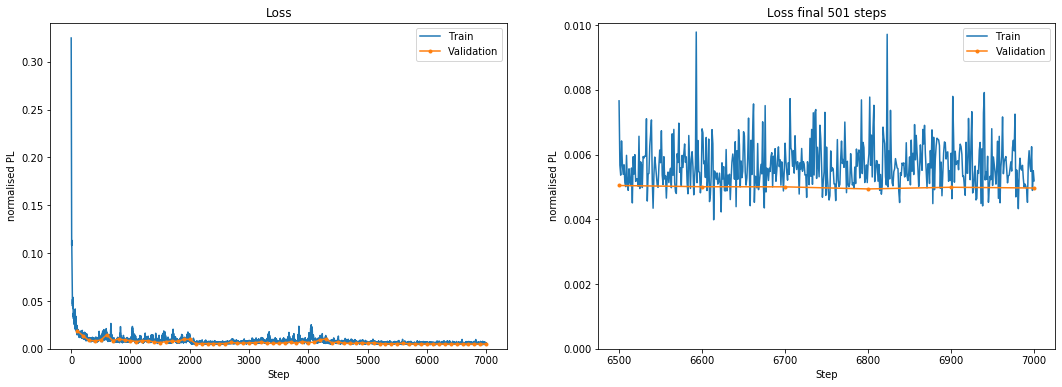

100/100 [==============================] - 10s 102ms/step - loss: 0.0056 - q0_loss: 5.2865e-05 - q1_loss: 1.8591e-04 - q2_loss: 6.9002e-04 - q3_loss: 8.5845e-04 - q4_loss: 0.0011 - q5_loss: 0.0011 - q6_loss: 9.3046e-04 - q7_loss: 4.2282e-04 - q8_loss: 2.6593e-04 - val_loss: 0.0050 - val_q0_loss: 5.6818e-05 - val_q1_loss: 1.9413e-04 - val_q2_loss: 6.9917e-04 - val_q3_loss: 8.6164e-04 - val_q4_loss: 0.0011 - val_q5_loss: 9.4368e-04 - val_q6_loss: 7.8414e-04 - val_q7_loss: 2.5114e-04 - val_q8_loss: 1.0196e-04


In [136]:
# train
history = model.fit(train_batch_creator.flow(), epochs=epochs, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[lr_callback, logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.23530573253943657, 'WSPL': 0.23530573253943657}


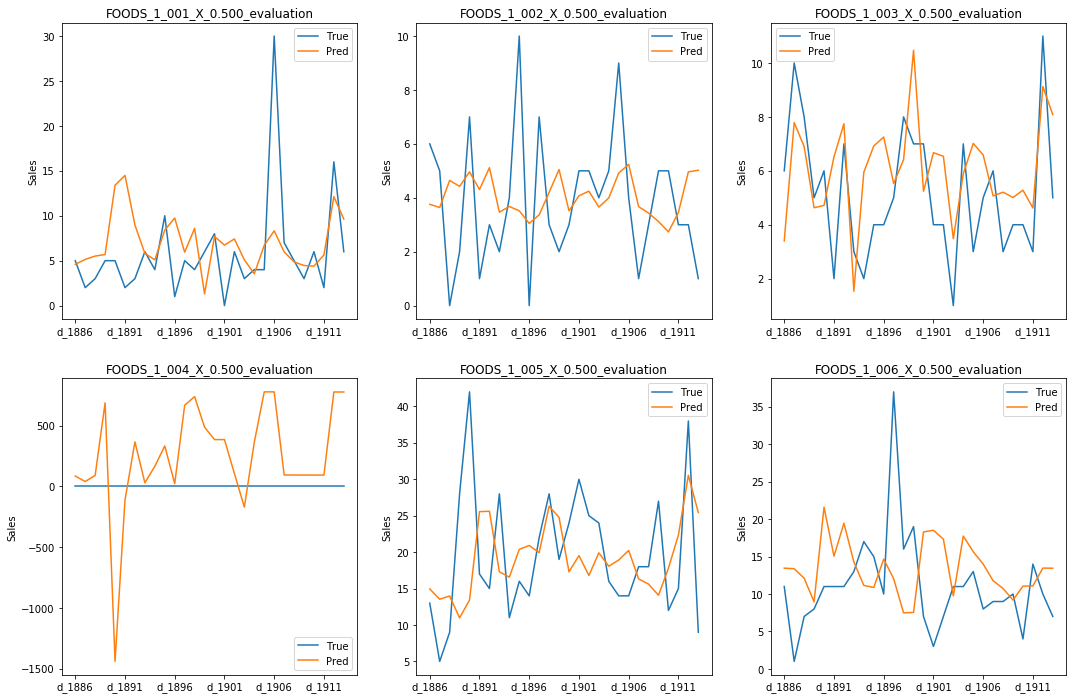

In [145]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

### One more try before real experiments

In [146]:
embed_shapes_inp

{'item_id': 3049,
 'dept_id': 7,
 'cat_id': 3,
 'event_name_1': 31,
 'event_type_1': 5,
 'event_name_2': 2,
 'event_type_2': 2,
 'year': 3,
 'month': 12,
 'week': 53,
 'day': 31,
 'dayofweek': 7}

In [147]:
embed_shapes_out = {
    'item_id': 100,
    'dept_id': 7,
    'cat_id': 3,
    'event_name_1': 31,
    'event_type_1': 5,
    'event_name_2': 2,
    'event_type_2': 2,
    'year': 3,
    'month': 12,
    'week': 53,
    'day': 31,
    'dayofweek': 7
}

In [148]:
# model setup
INP_SHAPE = len(plain_features)
model = get_embed_dist_model(INP_SHAPE, embed_shapes_inp, embed_shapes_out, num_nodes=256)
model.compile(optimizer=Adam(learning_rate=1e-5), loss=losses)
model.summary()

logger = Logger(val_batch_creator)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_item_id (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_dept_id (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_cat_id (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_event_name_1 (InputLayer) [(None, 1)]          0                                            
______________________________________________________________________________________________

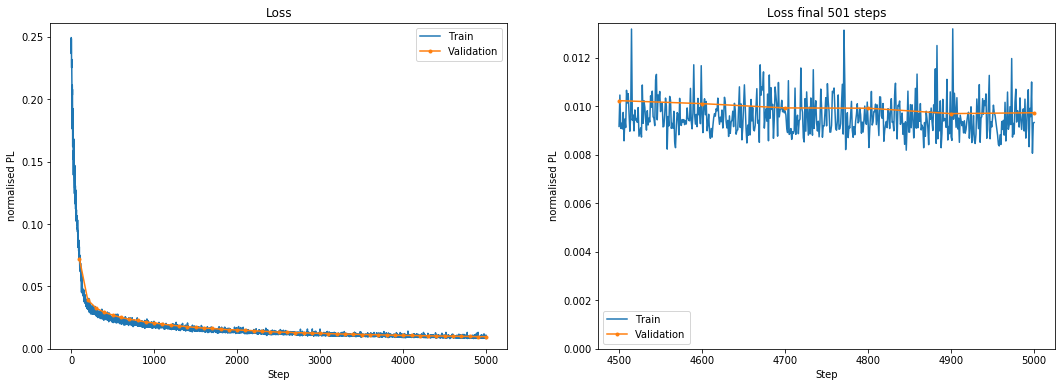

100/100 [==============================] - 11s 107ms/step - loss: 0.0095 - q0_loss: 1.5880e-04 - q1_loss: 4.0608e-04 - q2_loss: 0.0013 - q3_loss: 0.0015 - q4_loss: 0.0018 - q5_loss: 0.0018 - q6_loss: 0.0015 - q7_loss: 6.1261e-04 - q8_loss: 3.3563e-04 - val_loss: 0.0097 - val_q0_loss: 1.8067e-04 - val_q1_loss: 4.5863e-04 - val_q2_loss: 0.0014 - val_q3_loss: 0.0017 - val_q4_loss: 0.0019 - val_q5_loss: 0.0017 - val_q6_loss: 0.0015 - val_q7_loss: 5.7006e-04 - val_q8_loss: 2.9194e-04


In [149]:
# train
history = model.fit(train_batch_creator.flow(), epochs=epochs, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

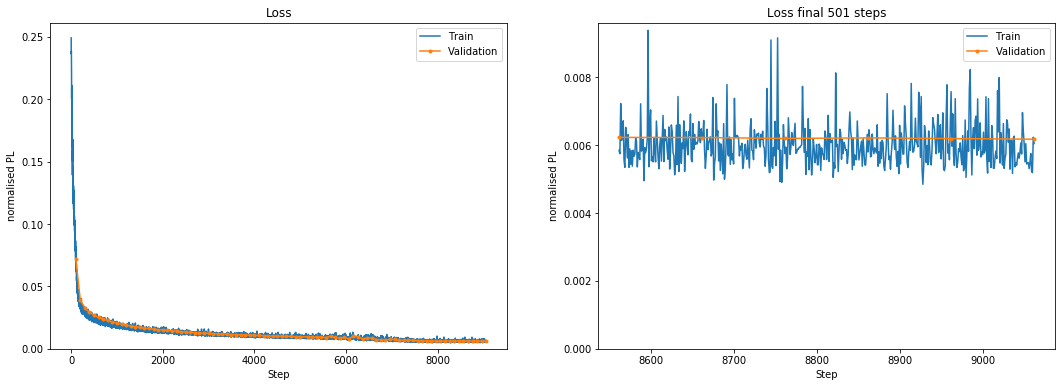

100/100 [==============================] - 11s 108ms/step - loss: 0.0060 - q0_loss: 7.7368e-05 - q1_loss: 2.3383e-04 - q2_loss: 8.2159e-04 - q3_loss: 0.0010 - q4_loss: 0.0012 - q5_loss: 0.0011 - q6_loss: 9.5543e-04 - q7_loss: 3.5041e-04 - q8_loss: 1.7372e-04 - val_loss: 0.0062 - val_q0_loss: 1.0346e-04 - val_q1_loss: 2.7720e-04 - val_q2_loss: 9.0414e-04 - val_q3_loss: 0.0011 - val_q4_loss: 0.0013 - val_q5_loss: 0.0011 - val_q6_loss: 9.4698e-04 - val_q7_loss: 3.2017e-04 - val_q8_loss: 1.4229e-04


In [156]:
epochs = 40
peak_lr = 1e-4
lr_scheduler_func = get_pyramid_lr(lr_start=peak_lr/10, lr_max=peak_lr, n_epoch=epochs)
lr_callback = LearningRateScheduler(lr_scheduler_func, verbose=1)

# train
history = model.fit(train_batch_creator.flow(), epochs=epochs, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[lr_callback, logger])